In [1]:
import numpy as np
import scipy.constants as constants
import matplotlib.pyplot as plt
import matplotlib
import os
import pandas as pd

import blackbody as bb
import detailedbalance as db
import plots as plots

#font = {'size' : 14}

matplotlib.rc('font',**{'size' : 16})
%matplotlib inline

In [2]:
# Just some constants for the upcoming math
c = constants.value('speed of light in vacuum')
h = constants.value('Planck constant in eV s')
e = constants.value('elementary charge')
k = constants.value('Boltzmann constant in eV/K')

pi = 3.1415

# Globals
Tcell = 300  # Kelvin
# Energy Gap
Egap = 1.1  #electron volts

In [3]:
E_ph = np.arange(0.01, 10,0.001) 
E_ph = np.flip(E_ph,0)

E_gaps = np.arange(0.3, 5,0.01) 
E_gaps = np.flip(E_gaps,0)

sourcetype = 0 

constants = {}

# sourcetype 1 for sun and 0 for full angle. This should perhaps be combined with the max_eff_temp function
if(sourcetype):
    #Sun
    constants['Temp'] = 5750
    constants['solidangle'] = db.solid_angle_sun(r_earth,d_sun)
    constants['emitterarea'] = 4*pi*r_sun**2
    constants['absorberarea'] = pi*r_earth**2
else:
    #Custom
    constants['Temp'] = 1800
    constants['solidangle'] = 2*pi
    constants['emitterarea'] = 1
    constants['absorberarea'] = 1
    
#emissivity = bb.stepfn(1,1,1.1,E_ph)

#constants['emissivity'] = bb.stepfn(10**-10,10**-30,1.1,E_ph)

emissivity = bb.lorentzian(0,1,1.5,0.1,E_ph)


BB = bb.rad_blackbody(E_ph,constants)
BB = BB * emissivity

#check integrated irradiance is ~1kW/m^2
# integrate = -np.trapz(BB[:,1],BB[:,0] )
# print(integrate)

#BB[:,1] = BB[:,1]/integrate
#BB[:,1] = BB[:,1]
#BB[:,1] = 0


BB_ph = bb.power_to_photons(BB)

#print(bb.stephan(5750)*4*pi*r_sun**2)


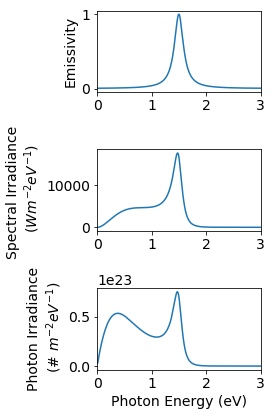

In [4]:
plots.em_ir_ph_plot(BB, BB_ph, emissivity)

(0, 3)

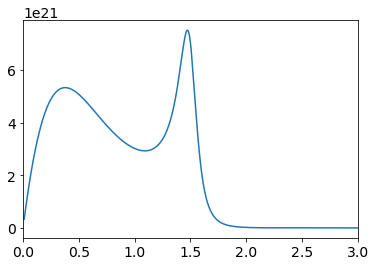

In [12]:
filt_wl = 1240/450
filt = bb.lorentzian(0.1,1,filt_wl,0.01,E_ph)

plt.plot(E_ph, filt*BB_ph)
plt.xlim(0,3)